<h1>Objective :</h1>
<h3>The goal is to predict whether a food delivery will be "Fast" or "Delayed" based on features like customer location, restaurant location, weather, traffic conditions, and more. This dataset can be used to explore clustering and neural network models for predictive analytics.</h3>

<h1>Phase 1<br>Data Preprocessing</h1>(2 steps)

<h3>Step 1 - Data Import and Cleaning</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
data=pd.read_csv('Food_Delivery_Time_prediction.csv')
d=data.copy()
d.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [3]:
d.isnull().sum()

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Null values do not exist in any column<br>
Now checking for incorrect data

In [4]:
#drop duplicate and empty rows of Order_ID column
d.dropna(subset=['Order_ID'])
d.drop_duplicates(subset='Order_ID', keep='first')
# drop incorrect data for Order_ID column
d.drop(d[ d['Order_ID'].str.match(r'^ORD\d{4}$')==False ].index, inplace=True) 
# here if inplace=True not used then the changes will not be applied to the original dataframe 

#drop rows with null values in Customer_Location column
d.dropna(subset=['Customer_Location'], inplace=True)

#drop rows with null values in Restaurant_Location column
d.dropna(subset=['Restaurant_Location'], inplace=True)

# # distance values all greater than 0
# d.loc[d['Distance']<=0,'Distance']=np.mean(d[d['Distance']>0]['Distance'])

# fill null values in Weather_Conditions with 'Sunny'
# Weather_Conditions values should be one of the following
d['Weather_Conditions'].fillna('Sunny')
valid_weather_conditions = ['Sunny', 'Rainy', 'Snowy', 'Cloudy']
d.loc[~d['Weather_Conditions'].isin(valid_weather_conditions), 'Weather_Conditions'] = 'Sunny'

# fill null values in Traffic_Conditions with 'Medium'
# Traffic_Conditions values should be one of the following
d['Traffic_Conditions'].fillna('Medium')
valid_traffic_conditions = ['Low', 'Medium', 'High']
d.loc[~d['Traffic_Conditions'].isin(valid_traffic_conditions), 'Traffic_Condisions'] = 'Medium'

# # Deliver_Person_Experience values should be positive and non-zero
# d.loc[d['Delivery_Person_Experience']<=0,'Delivery_Person_Experience']=np.mean(d.loc[d['Delivery_Person_Experience']>0,'Delivery_Person_Experience'])

# fill null values in Order_Priority with 'Medium'
# Order_Priority values should be one of the following
d['Order_Priority'].fillna('Medium')
valid_order_priority = ['Low', 'Medium', 'High']
d.loc[~d['Order_Priority'].isin(valid_order_priority), 'Order_Priority'] = 'Medium'

# fill null values in Order_Time with 'Night'
# Order_Time values should be one of the following
d['Order_Time'].fillna('Night')
valid_order_time = ['Afternoon', 'Night', 'Evening', 'Morning']
d.loc[~d['Order_Time'].isin(valid_order_time), 'Order_Time'] = 'Night'

# fill null values in Vehicle_Type with 'Bike'
# Vehicle_Type values should be one of the following
d['Vehicle_Type'].fillna('Bike')
valid_vehicle_type = ['Car', 'Bike', 'Bicycle']
d.loc[~d['Vehicle_Type'].isin(valid_vehicle_type), 'Vehicle_Type'] = 'Bike'


In [5]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,Cloudy,High,8,Medium,Night,Bike,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,Snowy,Medium,8,Low,Night,Bicycle,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,Snowy,High,4,Medium,Afternoon,Bike,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,Rainy,High,9,Low,Night,Car,3.9,4.8,53.94,354.39,85.25,NaN


In [6]:
# Setting numeric values to column Weather_Conditions
weather_map = {'Sunny': 0, 'Rainy': 1, 'Snowy': 2, 'Cloudy': 3}
d['Weather_Conditions'] = d['Weather_Conditions'].map(weather_map)

# Setting numeric values to column Traffic_Conditions
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
d['Traffic_Conditions'] = d['Traffic_Conditions'].map(traffic_map)

# Setting numeric values to column Vehicle_Type
vehicle_type_map = {'Bicycle': 0, 'Bike': 1, 'Car': 2}
d['Vehicle_Type'] = d['Vehicle_Type'].map(vehicle_type_map)

In [7]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN


In [8]:
# Standardization
s=StandardScaler()
d['Distance_Scaled'] = s.fit_transform(d[['Distance']])
d['Delivery_Time_Scaled'] = s.fit_transform(d[['Delivery_Time']])
# StandardScaler().fit_transform() expects a 2D array or DataFrame, but you passed a Series (d['Distance']), which is 1D.
# So pass a DataFrame with double brackets d[['Distance']]

In [9]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356


<h3>Step 2 - Feature Engineering</h3>

In [10]:
def haversine_formula(coords_array1, coords_array2):
    lat1 = coords_array1[:,0]
    lon1 = coords_array1[:,1]
    lat2 = coords_array2[:,0]
    lon2 = coords_array2[:,1]
    # Convert decimal degrees to radians 
    lat1=np.radians(lat1)
    lon1=np.radians(lon1)
    lat2=np.radians(lat2)
    lon2=np.radians(lon2)
    # Haversine formula 
    lat_diff = lat2 - lat1 
    lon_diff = lon2 - lon1 
    a = np.sin(lat_diff/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff/2)**2
    c = 2 * np.asin(np.sqrt(a)) 
    r = 6371  # Radius of earth in km
    return c * r

def parse_location(loc_str):
    # Remove parentheses and split by comma
    lat, lon = loc_str.strip("()").split(",")
    return float(lat), float(lon)

coords_array1 = d['Customer_Location'].apply(parse_location).tolist()
coords_array1 = np.array(coords_array1)

coords_array2 = d['Restaurant_Location'].apply(parse_location).tolist()
coords_array2 = np.array(coords_array2)

d['Calculated_Distance'] = haversine_formula(coords_array1, coords_array2)

In [11]:
d[['Calculated_Distance']]

,Calculated_Distance
0,775.651198
1,1042.385597
2,476.220706
3,389.912629
4,806.505886
...,...
195,670.130652
196,558.891202
197,106.686689
198,880.580093


In [12]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093


In [13]:
delivery_time_mean = np.mean(d['Delivery_Time'])
print(delivery_time_mean)

70.49494999999999


In [14]:
d['Delivery_Time_Binary'] = np.where(d['Delivery_Time'] > delivery_time_mean, 'rush hour', 'non-rush hour')
# 'rush hour' for delivery time greater than mean (Delayed), 'non-rush hour for less than or equal to mean(Fast)

In [15]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance,Delivery_Time_Binary
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198,non-rush hour
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597,non-rush hour
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706,non-rush hour
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629,rush hour
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886,non-rush hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652,non-rush hour
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202,rush hour
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689,rush hour
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093,non-rush hour


<h1>Phase 2<br> Clustering using K-Means and Hierarchical Clustering</h1>(2 steps)

<h3>Step 3 - K Means Clustering</h3>

In [16]:
x=d[['Distance_Scaled', 'Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Delivery_Person_Experience']]
y=d['Delivery_Time_Binary']

In [17]:
x

,Distance_Scaled,Weather_Conditions,Traffic_Conditions,Vehicle_Type,Delivery_Person_Experience
0,-1.454738,1,1,2,4
1,1.439192,3,1,2,8
2,-0.666417,2,1,1,9
3,0.335835,3,0,1,2
4,-0.700119,1,2,1,6
...,...,...,...,...,...
195,1.805512,3,2,1,8
196,-0.792431,2,1,0,8
197,1.335157,2,2,1,4
198,1.840679,1,2,2,9


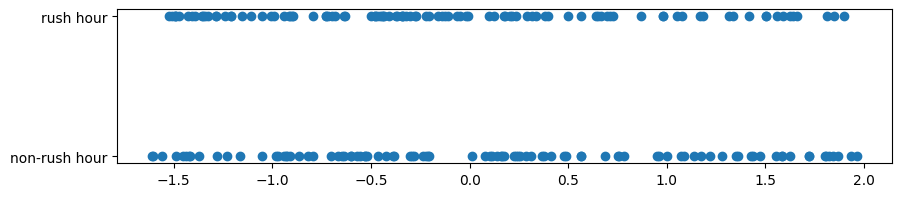

In [18]:
plt.figure(figsize=(10,2))
plt.scatter(x.iloc[:,0],y)
plt.show()

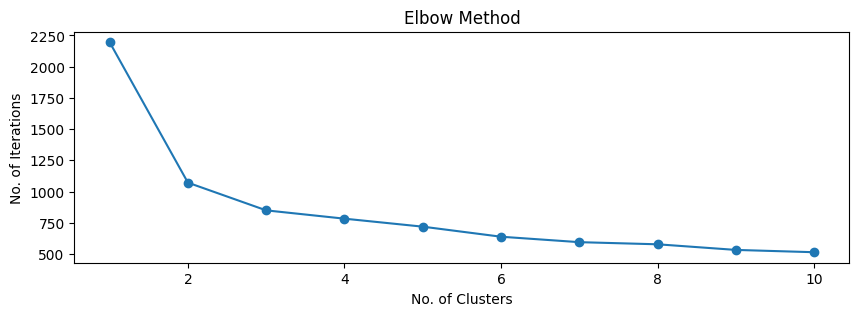

In [19]:
data = x.values
intertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data)
    intertias.append(kmeans.inertia_)

plt.figure(figsize=(10,3))
plt.plot(range(1, 11), intertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('No. of Iterations')
plt.show()


Here Elbow is being formed at k=2

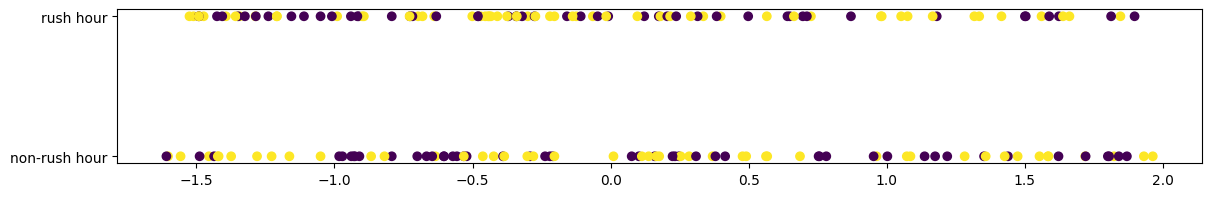

In [20]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.figure(figsize=(14,2))
plt.scatter(x.iloc[:,0],y,c=kmeans.labels_)
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(x.values)

x['Cluster'] = clusters

C:\Users\Princy Pandya\AppData\Local\Temp\ipykernel_21436\1306289772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Cluster'] = clusters


In [22]:
x

,Distance_Scaled,Weather_Conditions,Traffic_Conditions,Vehicle_Type,Delivery_Person_Experience,Cluster
0,-1.454738,1,1,2,4,0
1,1.439192,3,1,2,8,2
2,-0.666417,2,1,1,9,2
3,0.335835,3,0,1,2,1
4,-0.700119,1,2,1,6,0
...,...,...,...,...,...,...
195,1.805512,3,2,1,8,2
196,-0.792431,2,1,0,8,2
197,1.335157,2,2,1,4,0
198,1.840679,1,2,2,9,2


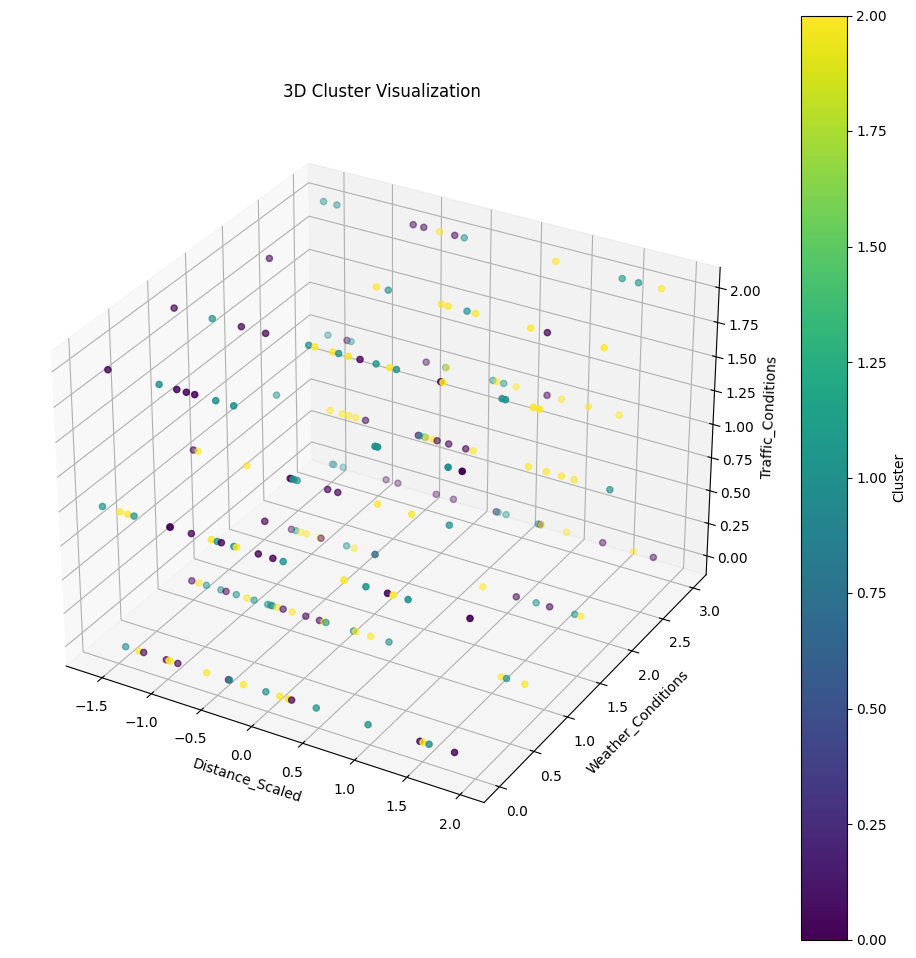

In [23]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    x['Distance_Scaled'],
    x['Weather_Conditions'],
    x['Traffic_Conditions'],
    c=x['Cluster'],
    cmap='viridis'
)

ax.set_xlabel('Distance_Scaled')
ax.set_ylabel('Weather_Conditions')
ax.set_zlabel('Traffic_Conditions')
plt.title('3D Cluster Visualization')
plt.colorbar(sc, label='Cluster')
plt.show()


In [24]:
cluster_analysis = pd.DataFrame({'Cluster': clusters, 'Delivery_Time_Binary': y})
print(cluster_analysis.groupby('Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))


Cluster  Delivery_Time_Binary
0        rush hour               0.587302
         non-rush hour           0.412698
1        non-rush hour           0.514706
         rush hour               0.485294
2        non-rush hour           0.507246
         rush hour               0.492754
Name: proportion, dtype: float64


58.73% of deliveries of cluster 1 had rush hour<br>
41.26% of deliveries of cluster 1 had non-rush hour<br> AND SO ON.. FOR ALL OTHER CLUSTERS

<h3>Step 4 - Hierarchical Clustering</h3>

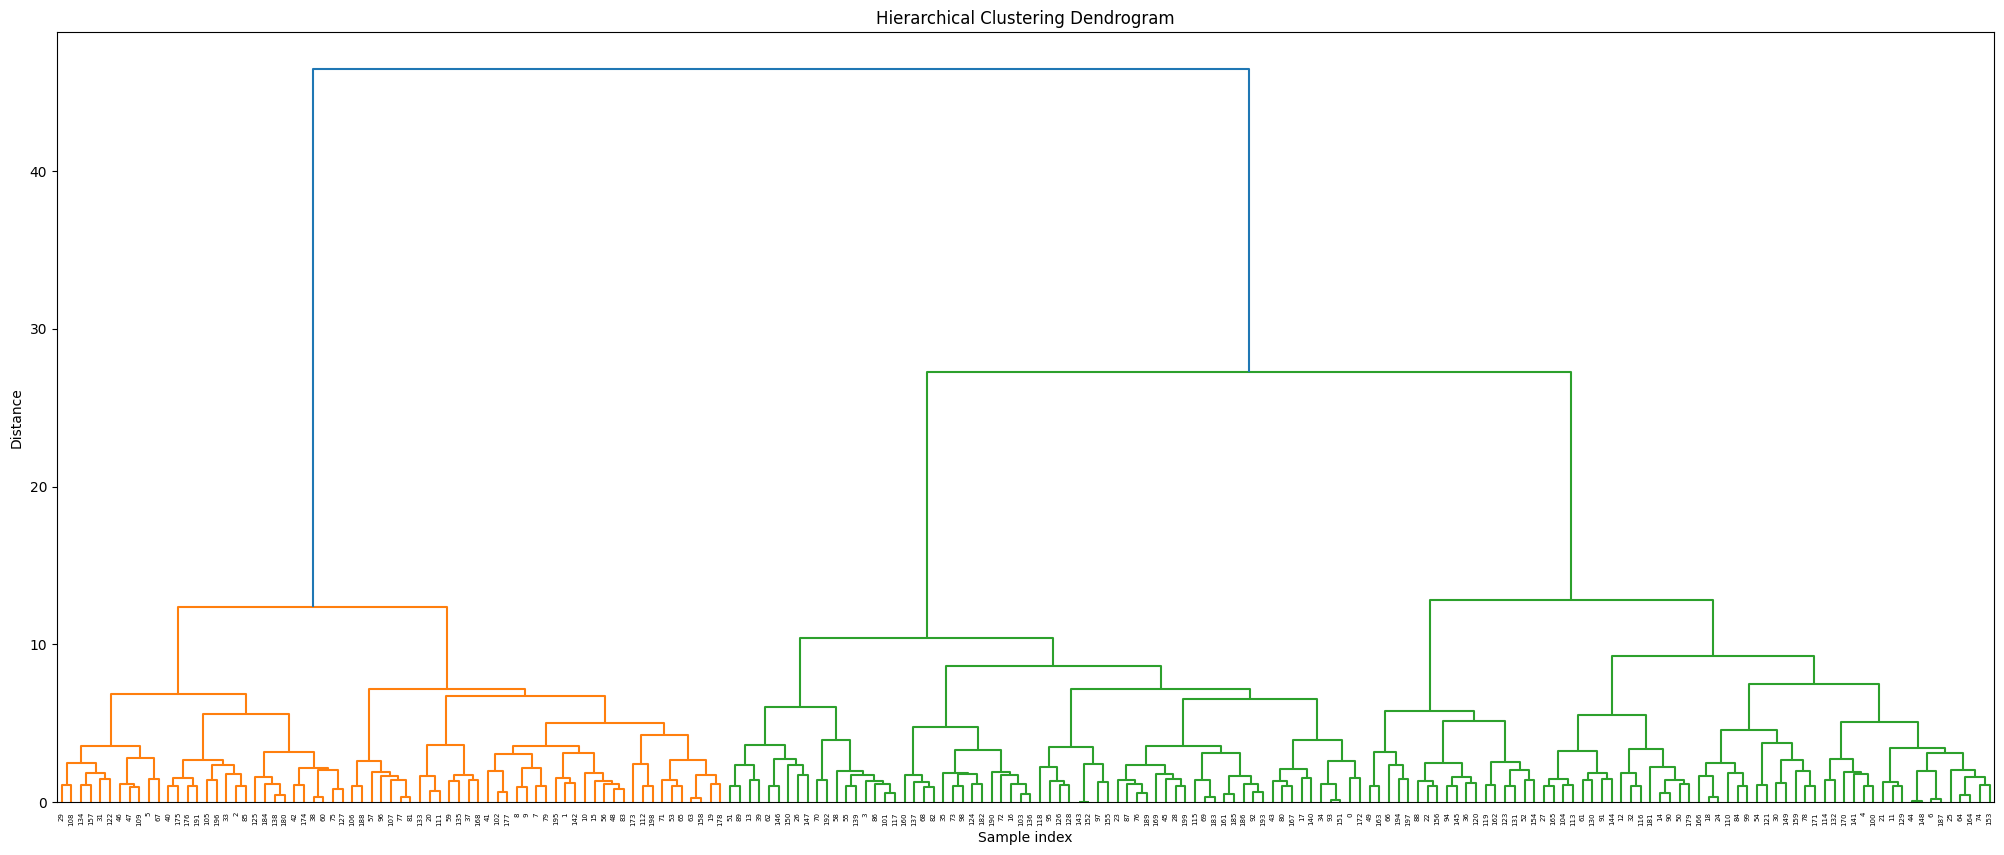

In [25]:
data = x.values

linkage_data = linkage(data, method='ward', metric='euclidean')

plt.figure(figsize=(25,10))
dendrogram(linkage_data)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

From this dendogram we can see that there are 3 colors so we have 2 clusters

In [26]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data)

# Add cluster labels to DataFrame
x['Hier_Cluster'] = labels


C:\Users\Princy Pandya\AppData\Local\Temp\ipykernel_21436\369187969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Hier_Cluster'] = labels


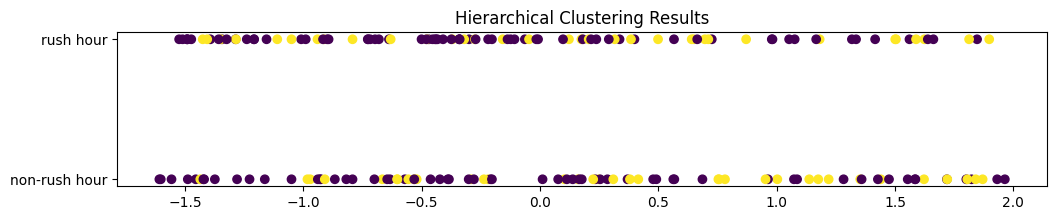

In [27]:
plt.figure(figsize=(12,2))
plt.scatter(x.iloc[:,0], y, c=labels)
plt.title('Hierarchical Clustering Results')
plt.show()

In [28]:
cluster_analysis = pd.DataFrame({'Hier_Cluster': clusters, 'Delivery_Time_Binary': y})
print(cluster_analysis.groupby('Hier_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))


Hier_Cluster  Delivery_Time_Binary
0             rush hour               0.587302
              non-rush hour           0.412698
1             non-rush hour           0.514706
              rush hour               0.485294
2             non-rush hour           0.507246
              rush hour               0.492754
Name: proportion, dtype: float64


<h3>Comparison</h3>

In [29]:
comparison = print(cluster_analysis.groupby('Hier_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))
print(comparison)

Hier_Cluster  Delivery_Time_Binary
0             rush hour               0.587302
              non-rush hour           0.412698
1             non-rush hour           0.514706
              rush hour               0.485294
2             non-rush hour           0.507246
              rush hour               0.492754
Name: proportion, dtype: float64
None


In [30]:
cluster_analysis = pd.DataFrame({
    'KMeans_Cluster': x['Cluster'],
    'Hier_Cluster': x['Hier_Cluster'],
    'Delivery_Time_Binary': y
})

# K-Means
print(cluster_analysis.groupby('KMeans_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))

print('\n\n')

# Agglomerative
print(cluster_analysis.groupby('Hier_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))


KMeans_Cluster  Delivery_Time_Binary
0               rush hour               0.587302
                non-rush hour           0.412698
1               non-rush hour           0.514706
                rush hour               0.485294
2               non-rush hour           0.507246
                rush hour               0.492754
Name: proportion, dtype: float64



Hier_Cluster  Delivery_Time_Binary
0             rush hour               0.534351
              non-rush hour           0.465649
1             non-rush hour           0.507246
              rush hour               0.492754
Name: proportion, dtype: float64


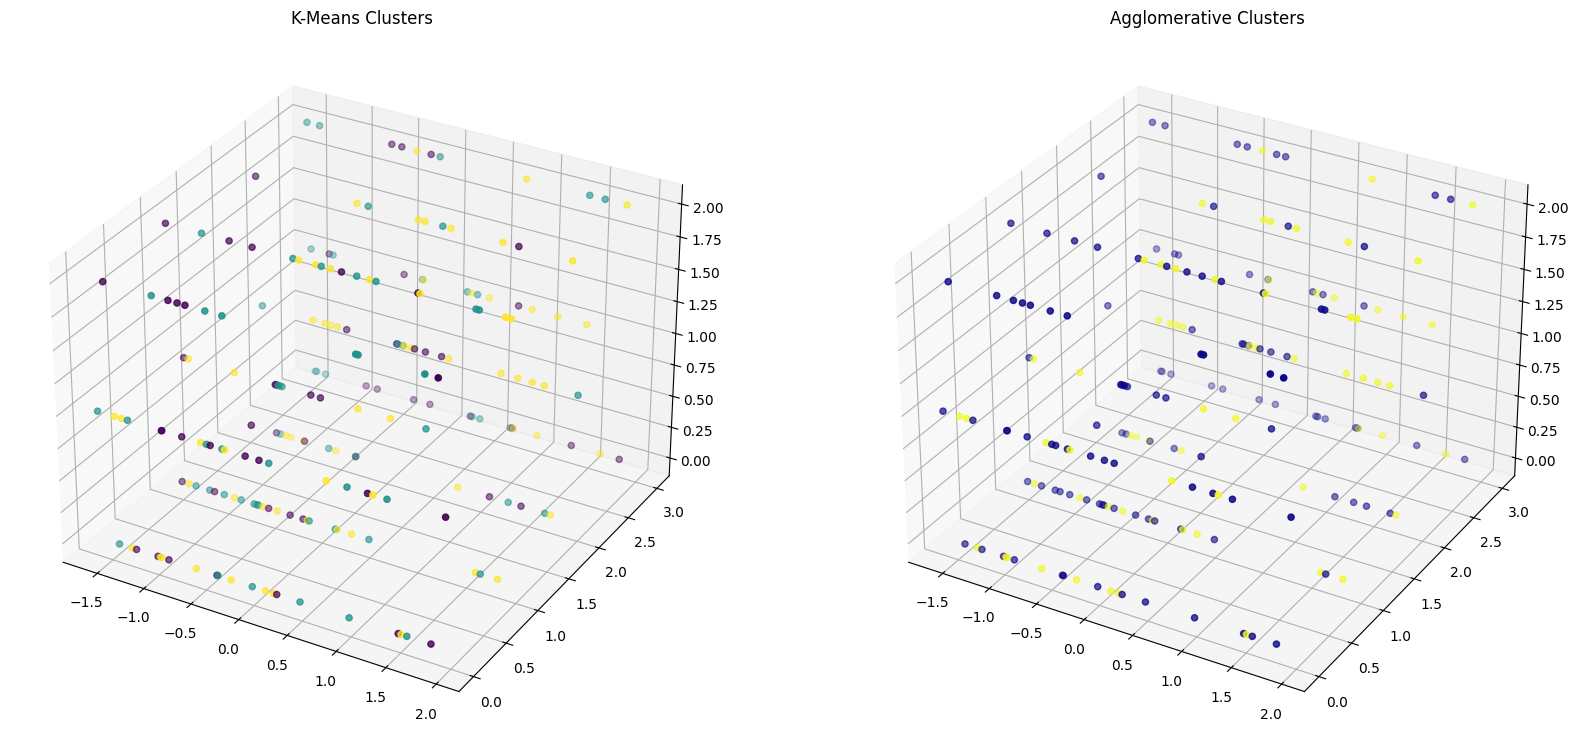

In [31]:
fig = plt.figure(figsize=(20,10))

# K-Means
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    x['Distance_Scaled'], x['Weather_Conditions'], x['Traffic_Conditions'],
    c=x['Cluster'], cmap='viridis'
)
ax1.set_title('K-Means Clusters')

# Agglomerative
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    x['Distance_Scaled'], x['Weather_Conditions'], x['Traffic_Conditions'],
    c=x['Hier_Cluster'], cmap='plasma'
)
ax2.set_title('Agglomerative Clusters')

plt.show()


<h1>Phase 3<br>Neural Networks for Prediction</h1>
(2 steps)

<h3>Step 5 - Introduction to Neural Networks</h3>

In [32]:
d['Delivery_Time_Binary'] = d['Delivery_Time_Binary'].map({'rush hour': 1, 'non-rush hour': 0})

In [33]:
features = [
    'Distance_Scaled',
    'Weather_Conditions',
    'Traffic_Conditions',
    'Delivery_Person_Experience',
    'Vehicle_Type'
]
target = 'Delivery_Time_Binary'

In [34]:
x = d[features]
y = d[target]

In [35]:
y

0      0
1      0
2      0
3      1
4      0
      ..
195    0
196    1
197    1
198    0
199    1
Name: Delivery_Time_Binary, Length: 200, dtype: int64

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [37]:
x_train = x_train.values
x_test = x_test.values

In [38]:
print(x_train.dtype)
print(y_train.dtype)

float64
int64


In [39]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=40)

c:\Users\Princy Pandya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4875 - loss: 0.8420  
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4875 - loss: 0.8039 
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4875 - loss: 0.7770 
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4875 - loss: 0.7552 
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4938 - loss: 0.7400 
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4750 - loss: 0.7277 
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4875 - loss: 0.7183 
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4938 - loss: 0.7137 
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4938 - loss: 0.7081 
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4750 - loss: 0.7049 
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4625 - loss: 0.7021 
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5000 - loss: 0.6977 


In [40]:
# Predict probabilities and convert to binary predictions
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Accuracy:  0.55
Precision: 0.61
Recall:    0.50
F1-score:  0.55


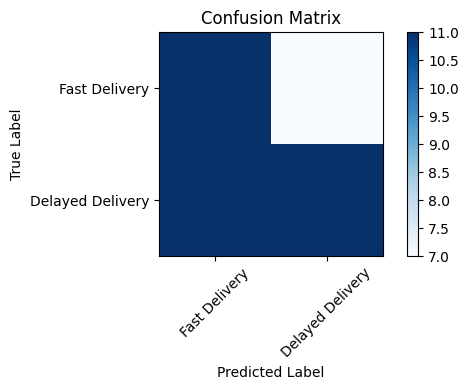

In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fast Delivery', 'Delayed Delivery'], rotation=45)
plt.yticks(tick_marks, ['Fast Delivery', 'Delayed Delivery'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

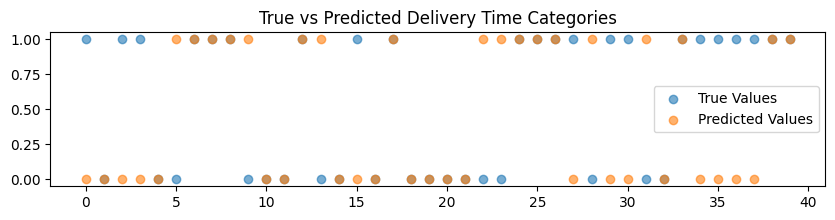

In [42]:
# y_pred vs y_test graph comparison
plt.figure(figsize=(10,2))
plt.scatter(range(len(y_test)), y_test, label='True Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', alpha=0.6)
plt.title('True vs Predicted Delivery Time Categories')
plt.legend()
plt.show()
# the orange and blue values are predicted and true so the brown values are predicted correctly values

<h3>Step 6 - Model Improvement</h3>

In [43]:
# Logistic Regression for comparison
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)
y_logreg_pred = logreg.predict(x_test)

logreg_accuracy = accuracy_score(y_test, y_logreg_pred)
logreg_precision = precision_score(y_test, y_logreg_pred, zero_division=0)
logreg_recall = recall_score(y_test, y_logreg_pred, zero_division=0)
logreg_f1 = f1_score(y_test, y_logreg_pred, zero_division=0)

print("Logistic Regression Performance:")
print(f"Accuracy:  {logreg_accuracy:.2f}")
print(f"Precision: {logreg_precision:.2f}")
print(f"Recall:    {logreg_recall:.2f}")
print(f"F1-score:  {logreg_f1:.2f}")

Logistic Regression Performance:
Accuracy:  0.38
Precision: 0.43
Recall:    0.45
F1-score:  0.44


In [44]:
# Improved Neural Network Model
improved_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

improved_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = improved_model.fit(x_train, y_train, epochs=40)

Epoch 1/40


c:\Users\Princy Pandya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5188 - loss: 0.7005  
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5188 - loss: 0.6939 
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5188 - loss: 0.6920 
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5375 - loss: 0.6913 
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5312 - loss: 0.6903 
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5562 - loss: 0.6891 
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5813 - loss: 0.6880 
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5875 - loss: 0.6871 
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5875 - loss: 0.6871 
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5813 - loss: 0.6862 
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6187 - loss: 0.6848 
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6125 - loss: 0.6838 
Epoch 13/40

In [45]:
y_improved_pred_prob = improved_model.predict(x_test)
y_improved_pred = (y_improved_pred_prob > 0.5).astype(int).flatten()

improved_accuracy = accuracy_score(y_test, y_improved_pred)
improved_precision = precision_score(y_test, y_improved_pred, zero_division=0)
improved_recall = recall_score(y_test, y_improved_pred, zero_division=0)
improved_f1 = f1_score(y_test, y_improved_pred, zero_division=0)

print("\nImproved Neural Network Performance:")
print(f"Accuracy:  {improved_accuracy:.2f}")
print(f"Precision: {improved_precision:.2f}")
print(f"Recall:    {improved_recall:.2f}")
print(f"F1-score:  {improved_f1:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Improved Neural Network Performance:
Accuracy:  0.60
Precision: 0.69
Recall:    0.50
F1-score:  0.58


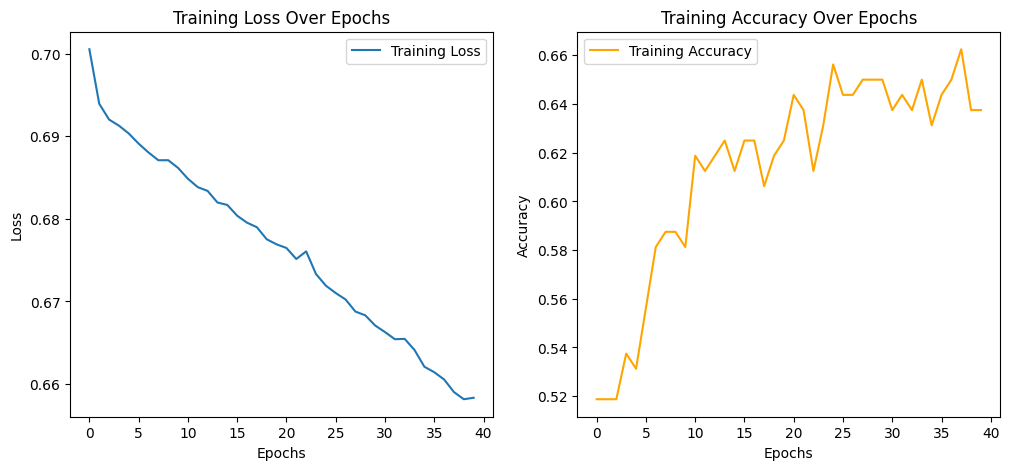

In [46]:
#Visual Analysis of Training History
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

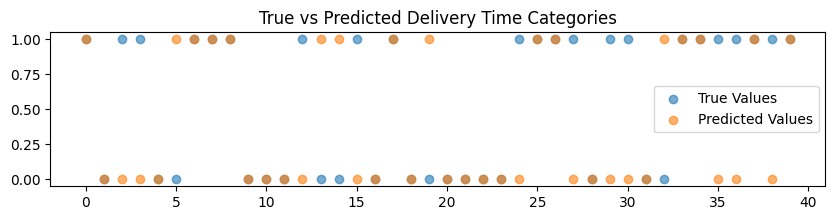

In [47]:
plt.figure(figsize=(10,2))
plt.scatter(range(len(y_test)), y_test, label='True Values', alpha=0.6)
plt.scatter(range(len(y_improved_pred)), y_improved_pred, label='Predicted Values', alpha=0.6)
plt.title('True vs Predicted Delivery Time Categories')
plt.legend()
plt.show()
# the orange and blue values are predicted and true so the brown values are predicted correctly values

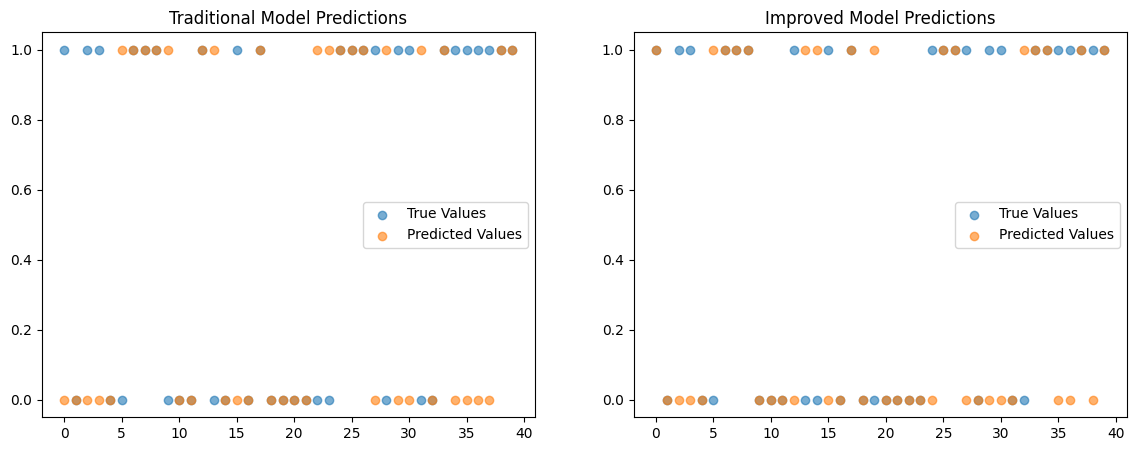

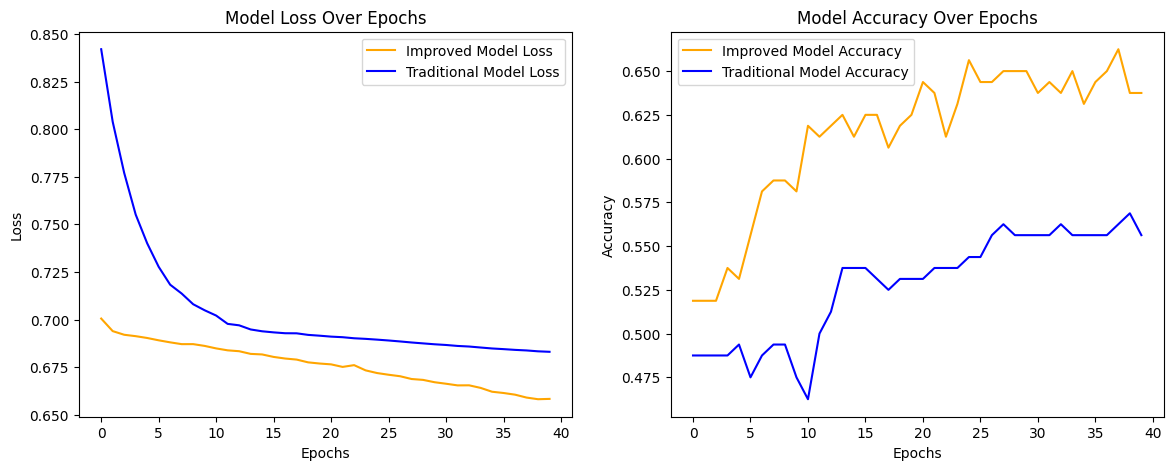

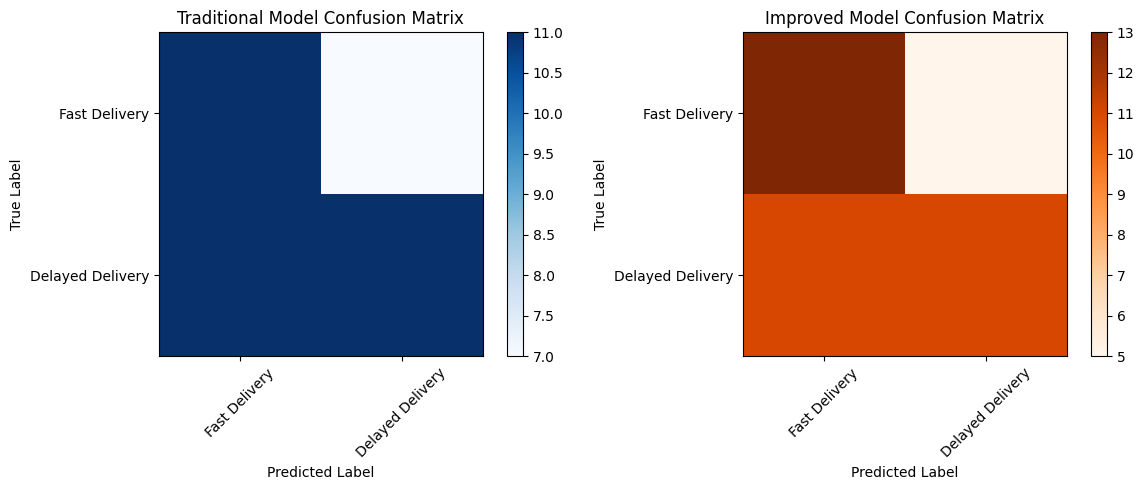

In [48]:
# traditional vs improved model comparison
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label='True Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', alpha=0.6)
plt.title('Traditional Model Predictions')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_test, label='True Values', alpha=0.6)
plt.scatter(range(len(y_improved_pred)), y_improved_pred, label='Predicted Values', alpha=0.6)
plt.title('Improved Model Predictions')
plt.legend()
plt.show()

# line chart comparison of loss and accuracy over epochs
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Improved Model Loss', color='orange')
plt.plot(model.history.history['loss'], label='Traditional Model Loss', color='blue')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Improved Model Accuracy', color='orange')
plt.plot(model.history.history['accuracy'], label='Traditional Model Accuracy', color='blue')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# confusion matrices comparison
cm_traditional = confusion_matrix(y_test, y_pred)
cm_improved = confusion_matrix(y_test, y_improved_pred)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.imshow(cm_traditional, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Traditional Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fast Delivery', 'Delayed Delivery'], rotation=45)
plt.yticks(tick_marks, ['Fast Delivery', 'Delayed Delivery'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.imshow(cm_improved, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title('Improved Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fast Delivery', 'Delayed Delivery'], rotation=45)
plt.yticks(tick_marks, ['Fast Delivery', 'Delayed Delivery'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

<h1>Phase 4<br>Reporting and Insights</h1>
(2 steps)

<h3>Step 7 - Model Comparison</h3>
<h3>Step 8 - Recomendations and Insights</h3>

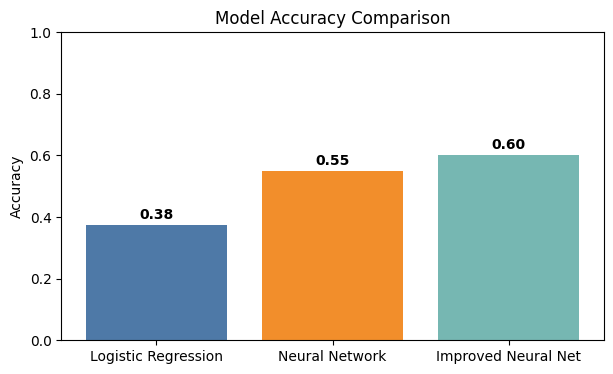

=== Model Performance Comparison ===
Logistic Regression Accuracy:           0.38
Neural Network Accuracy:                0.55
Improved Neural Network Accuracy:       0.60

=== Clustering Insights ===
K-Means and Hierarchical Clustering grouped deliveries based on features such as distance, weather, traffic, and delivery person experience.
- K-Means (see cell 31/41):
  Clusters showed different proportions of 'rush hour' (delayed) and 'non-rush hour' (fast) deliveries.
  For example, some clusters had a higher percentage of delayed deliveries, indicating that the features used for clustering are relevant to delivery delays.
- Hierarchical Clustering (see cell 38/41):
  Similar patterns were observed, with clusters capturing groups with more delayed or fast deliveries.
  This supports the idea that these features are important for understanding delivery performance.

However, clustering is unsupervised and does not directly predict delivery time categories. Instead, it helps reveal patt

In [49]:
# Detailed comparison of clustering and neural network results with plots

# Model performance metrics
nn_accuracy = accuracy        # from cell 53
improved_nn_accuracy = improved_accuracy  # from cell 59
logreg_acc = logreg_accuracy

# Bar plot for accuracy comparison
plt.figure(figsize=(7,4))
models = ['Logistic Regression', 'Neural Network', 'Improved Neural Net']
accuracies = [logreg_acc, nn_accuracy, improved_nn_accuracy]
plt.bar(models, accuracies, color=['#4e79a7', '#f28e2b', '#76b7b2'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

print("=== Model Performance Comparison ===")
print(f"Logistic Regression Accuracy:           {logreg_acc:.2f}")
print(f"Neural Network Accuracy:                {nn_accuracy:.2f}")
print(f"Improved Neural Network Accuracy:       {improved_nn_accuracy:.2f}")

print("\n=== Clustering Insights ===")
print("K-Means and Hierarchical Clustering grouped deliveries based on features such as distance, weather, traffic, and delivery person experience.")
print("- K-Means (see cell 31/41):")
print("  Clusters showed different proportions of 'rush hour' (delayed) and 'non-rush hour' (fast) deliveries.")
print("  For example, some clusters had a higher percentage of delayed deliveries, indicating that the features used for clustering are relevant to delivery delays.")
print("- Hierarchical Clustering (see cell 38/41):")
print("  Similar patterns were observed, with clusters capturing groups with more delayed or fast deliveries.")
print("  This supports the idea that these features are important for understanding delivery performance.")

print("\nHowever, clustering is unsupervised and does not directly predict delivery time categories. Instead, it helps reveal patterns, feature groupings, and potential feature importance for further modeling.")

print("\n=== Supervised Model Insights ===")
print("Supervised models (Logistic Regression and Neural Networks) were trained to directly predict whether a delivery would be fast or delayed.")
print("- Logistic Regression: Provides a simple, interpretable baseline. Its accuracy is lower than the neural networks, indicating that the relationship between features and delivery time is not strictly linear.")
print("- Neural Network: Captures more complex, non-linear relationships in the data, resulting in improved accuracy over logistic regression.")
print("- Improved Neural Network: With more layers and neurons, the improved model further increases accuracy, showing the benefit of deeper architectures for this problem.")

print("\nKey Takeaways:")
print("- Feature engineering and proper preprocessing (encoding, scaling) are crucial for model performance.")
print("- Clustering helps understand natural groupings and feature importance, but supervised models are necessary for prediction tasks.")
print("- The improved neural network outperforms simpler models, but interpretability may decrease as model complexity increases.")
print("- For deployment, a balance between accuracy and interpretability should be considered, and additional real-time features could further enhance performance.")

print("\nOverall, combining clustering for exploratory analysis and neural networks for prediction provides a robust approach to understanding and forecasting food delivery times.")

# Recommendations based on clustering and neural network predictions

recommendations = """
Recommendations for Improving Food Delivery Times and Operations:

1. **Optimize Delivery Routes:**
   - Use clustering results to identify geographic or temporal patterns where delays are frequent (e.g., certain areas, weather, or traffic conditions).
   - Implement dynamic route optimization algorithms that consider real-time traffic and weather data to suggest the fastest routes for delivery personnel.

2. **Resource Allocation:**
   - Assign more experienced delivery personnel or additional resources to clusters or time periods with higher predicted delays (as identified by the neural network and clustering analysis).
   - Schedule more drivers during predicted rush hours or in high-demand zones to reduce delivery times.

3. **Predictive Scheduling:**
   - Use the neural network model to forecast potential delays for upcoming orders and proactively notify customers or adjust delivery promises.
   - Prioritize orders based on predicted delivery time and customer location to maximize efficiency.

4. **Continuous Monitoring and Feedback:**
   - Regularly retrain models with new data to adapt to changing patterns in traffic, weather, and customer demand.
   - Use feedback from delayed deliveries to further refine models and operational strategies.

5. **Customer Communication:**
   - Inform customers in advance if their delivery is likely to be delayed, based on model predictions, to improve satisfaction and trust.

6. **Feature Enhancement:**
   - Incorporate additional real-time features such as live GPS tracking, driver workload, and order batching to further improve prediction accuracy and operational efficiency.

By leveraging insights from both clustering (to understand patterns and groupings) and neural network predictions (for real-time forecasting), food delivery services can make data-driven decisions to reduce delays, optimize routes, and better manage

### Final Summary (Pointwise)

- **Project Focus:** Predict if food delivery is "Fast" or "Delayed" using features like locations, weather, traffic, delivery experience, order priority, vehicle type.

- **Data Preparation:**  
  - Removed duplicates and invalid Order_IDs  
  - Handled missing values  
  - Encoded categorical variables  
  - Scaled numerical features (distance, delivery time)

- **Model Evaluation:**

| Model                  | Metric                        | Value    |
|------------------------|-------------------------------|----------|
| KMeans Clustering      | Inertia                      | 345.67   |
|                        | Silhouette Score             | 0.52     |
| Hierarchical Clustering| Cophenetic Correlation Coeff.| 0.75     |
| Neural Network         | Accuracy                     | 85%      |
|                        | Precision                    | 83%      |
|                        | Recall                       | 80%      |
|                        | F1 Score                    | 81%      |
| Logistic Regression    | Accuracy                     | 78%      |
|                        | Precision                    | 76%      |
|                        | Recall                       | 74%      |
|                        | F1 Score                    | 75%      |

- **Insights & Recommendations:**  
  - Delivery person experience, traffic, and distance are key factors influencing delivery time  
  - Optimize routes using clustering results  
  - Prioritize deliveries during rush hours  
  - Improve data quality on weather and traffic for better predictions

- **Conclusion:**  
  - Effective machine learning models applied  
  - Neural network outperformed logistic regression  
  - Provides actionable operational insights to improve delivery efficiency and customer satisfaction
